# Machine Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

## Data Overview

In [2]:
labeled_path = r"labeled"
unlabeled_path = r"unlabeled"

labeled_files = [os.path.join(labeled_path, file) for file in os.listdir(labeled_path)]
unlabeled_files = [os.path.join(unlabeled_path, file) for file in os.listdir(unlabeled_path)]

## Feature Engineering

In [3]:
def audio_features(files):
    features_list = []

    for file in files:
        # Check if it's an audio file (you can expand the condition for specific extensions)
        if file.endswith(('.wav', '.mp3', '.flac')):
            try:
                # Load the audio file
                y, sr = librosa.load(file, sr=None)  # Use original sampling rate

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # MFCCs
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Spectral Bandwidth
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral Centroid
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)  # Roll-Off Frequency (85%)

                # Aggregate features (mean and standard deviation)
                feature_vector = {
                    'file_name': os.path.basename(file),
                    'mfccs_mean': np.mean(mfccs, axis=1).tolist(),
                    'mfccs_std': np.std(mfccs, axis=1).tolist(),
                    'chroma_mean': np.mean(chroma, axis=1).tolist(),
                    'spectral_contrast_mean': np.mean(spectral_contrast, axis=1).tolist(),
                    'spectral_bandwidth_mean': np.mean(spectral_bandwidth).tolist(),
                    'spectral_bandwidth_std': np.std(spectral_bandwidth).tolist(),
                    'spectral_centroid_mean': np.mean(spectral_centroid).tolist(),
                    'spectral_centroid_std': np.std(spectral_centroid).tolist(),
                    'rolloff_mean': np.mean(rolloff).tolist(),
                    'rolloff_std': np.std(rolloff).tolist(),
                }

                features_list.append(feature_vector)

            except Exception as e:
                print(f"Error processing {file}: {e}")
    return features_list


In [4]:
labeled_fl = audio_features(labeled_files)
unlabeled_fl = audio_features(unlabeled_files)

In [5]:
labeled_df = pd.DataFrame(labeled_fl).set_index('file_name')
unlabeled_df = pd.DataFrame(unlabeled_fl).set_index('file_name')

In [6]:
unlabeled_df

,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,
m00003.wav,"[-82.51111602783203, 97.34172058105469, -34.36...","[38.669281005859375, 17.976158142089844, 17.42...","[0.47129690647125244, 0.40974733233451843, 0.4...","[18.42324910196291, 14.811131697206996, 17.832...",2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,"[-1.9132977724075317, 72.6861572265625, -32.79...","[21.85912322998047, 17.475719451904297, 15.581...","[0.4568102955818176, 0.5573737621307373, 0.680...","[18.524160576331486, 13.818720668244472, 18.00...",2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,"[-287.60369873046875, 101.75817108154297, -35....","[70.5913314819336, 17.471935272216797, 14.6056...","[0.3978669047355652, 0.1438601016998291, 0.112...","[15.679685056568916, 18.681855999598262, 21.48...",1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,"[-120.14749145507812, 91.31721496582031, -38.8...","[44.28722381591797, 22.18126106262207, 23.4976...","[0.4205609858036041, 0.3527196943759918, 0.438...","[18.87152117386596, 14.35500698781533, 15.5682...",2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,"[-437.6044006347656, 170.93153381347656, 7.419...","[63.8968391418457, 28.720317840576172, 25.7035...","[0.12168776988983154, 0.10355798155069351, 0.3...","[14.75606253173177, 17.16370892840314, 22.3184...",900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...
m00971.wav,"[-246.1586456298828, 149.4286651611328, -41.98...","[76.47077941894531, 38.449031829833984, 15.516...","[0.3375800549983978, 0.2272903174161911, 0.499...","[17.927492352142526, 14.882813158957992, 19.21...",1588.217850,446.341219,1525.791709,459.815904,2733.184659,982.391092
m00973.wav,"[-8.573004722595215, 54.2957878112793, 20.9641...","[55.02655792236328, 23.15241813659668, 20.5675...","[0.3442322015762329, 0.4773417115211487, 0.461...","[20.139989902635932, 15.154152301920007, 19.01...",3295.063699,333.732126,3669.810467,938.109519,7876.372739,1289.897788
m00988.wav,"[-56.15306091308594, 36.44850158691406, 11.979...","[70.65717315673828, 33.994869232177734, 25.310...","[0.4564961791038513, 0.41816866397857666, 0.38...","[20.4345690226062, 17.928656849275942, 18.5909...",3361.641125,313.312735,3941.417696,1162.771630,8260.423162,1196.440796


In [7]:
# Final labeled DataFrame
class AudioFeatureExpander:
    def __init__(self, labeled_df):
        self.labeled_df = labeled_df
    def expand_features(self):
        # Define the features to expand and their respective lengths
        features_to_expand = {
            'mfccs_mean': 13,
            'mfccs_std': 13,
            'chroma_mean': 12,
            'spectral_contrast_mean': 7
        }
        expanded_features_df = pd.DataFrame(index=self.labeled_df.index)
        # Expand each feature
        for feature, length in features_to_expand.items():
            expanded_df = pd.DataFrame(self.labeled_df[feature].tolist(), index=self.labeled_df.index,
                                       columns=[f'{feature}_{i}' for i in range(length)])
            expanded_features_df = pd.concat([expanded_features_df, expanded_df], axis=1)
        # # Add the remaining features
        remaining_features = ['spectral_bandwidth_mean', 'spectral_bandwidth_std',
                              'spectral_centroid_mean', 'spectral_centroid_std',
                              'rolloff_mean', 'rolloff_std']
        expanded_features_df = pd.concat([expanded_features_df, self.labeled_df[remaining_features]], axis=1)
        return expanded_features_df

In [8]:
# Usage
expander = AudioFeatureExpander(unlabeled_df)
final_unlabeled_df = expander.expand_features()
display(final_unlabeled_df)

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-82.511116,97.341721,-34.367928,71.408501,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,38.669281,17.976158,17.420506,13.732415,9.274554,9.197666,9.216418,7.644602,7.794284,6.777957,7.380204,7.544622,7.064954,0.471297,0.409747,0.488772,0.442609,0.503924,0.427372,0.389844,0.410940,0.448522,0.488606,0.486308,0.662977,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,-1.913298,72.686157,-32.791992,63.605476,-18.556351,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954250,18.755697,-11.187991,21.859123,17.475719,15.581608,10.556849,8.347109,8.000425,8.903178,7.457137,7.373907,6.871805,6.721302,7.231080,6.247564,0.456810,0.557374,0.680655,0.526191,0.406365,0.417328,0.367432,0.334647,0.365308,0.423689,0.311572,0.326611,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,-287.603699,101.758171,-35.345409,41.280159,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,-8.788416,-0.053095,-13.757536,70.591331,17.471935,14.605653,7.484632,11.334907,7.317162,10.026291,7.892459,8.673855,9.159691,12.261617,8.443221,11.332116,0.397867,0.143860,0.112334,0.102700,0.387866,0.583642,0.278688,0.283264,0.192714,0.517787,0.310177,0.168636,15.679685,18.681856,21.483555,23.963961,24.473956,23.647332,34.825406,1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,-120.147491,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119441,23.654900,-14.630774,13.370975,-9.403306,13.706296,-9.315235,44.287224,22.181261,23.497639,14.564473,10.189630,10.347978,9.210693,8.198386,6.618116,8.076797,6.721008,5.650340,6.336876,0.420561,0.352720,0.438729,0.588503,0.809106,0.540158,0.336136,0.368313,0.400302,0.380119,0.425498,0.526869,18.871521,14.355007,15.568276,14.744588,16.072624,19.146556,39.286679,2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,-437.604401,170.931534,7.419581,-3.083473,0.789382,-11.128750,-12.522781,-6.907836,-5.858702,-8.461237,-8.481487,-8.339388,-7.378575,63.896839,28.720318,25.703560,11.270920,11.725130,11.461707,11.061062,10.545693,13.923300,11.246155,12.618073,14.727922,11.223578,0.121688,0.103558,0.303259,0.355438,0.127611,0.195966,0.140674,0.182006,0.287204,0.227969,0.408830,0.159130,14.756063,17.163709,22.318450,24.297561,24.119580,21.639522,17.475062,900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-246.158646,149.428665,-41.988865,11.606256,-10.289647,-4.019358,-7.136855,-10.135562,-9.420322,-7.171843,-3.158367,-5.640657,-2.586296,76.470779,38.449032,15.516282,9.866004,7.818055,7.556600,6.768150,8.246713,7.970279,7.855545,8.819655,7.837425,9.696887,0.337580,0.227290,0.499260,0.296814,0.362897,0.349061,0.208238,0.392273,0.218967,0.32106

In [9]:
numeric_features = final_unlabeled_df.select_dtypes(include=[np.number])


In [10]:
sns.set(style="darkgrid")

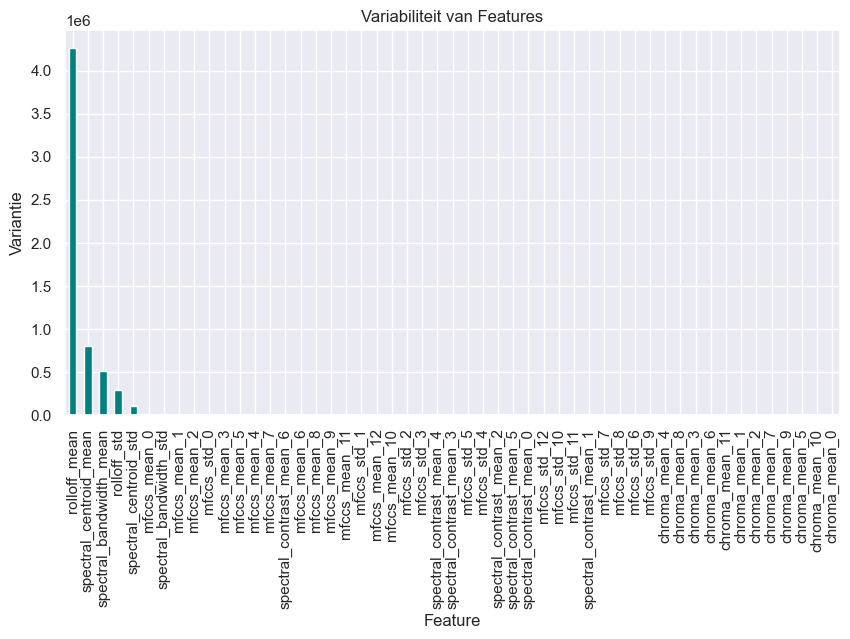

In [11]:
# Variabiliteit berekenen
feature_variability = numeric_features.var().sort_values(ascending=False)

# Plot de variabiliteit
plt.figure(figsize=(10, 5))
feature_variability.plot(kind='bar', color='teal')
plt.title('Variabiliteit van Features')
plt.ylabel('Variantie')
plt.xlabel('Feature')
plt.show()

## Modeling

## Results

## Conclusion & Advice

## Sources